In [ ]:
# Gerekli kütüphaneleri import edelim;

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, validation_curve,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", "{:.3f}".format)

warnings.filterwarnings("ignore",category = DeprecationWarning)
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category = UserWarning)





In [ ]:
# veri setini dahil edelim;
att_df = pd.read_csv(r"/content/drive/MyDrive/ML/Bonus2/dataset/scoutium_attributes.csv",sep = ";")
pl_df = pd.read_csv(r"/content/drive/MyDrive/ML/Bonus2/dataset/scoutium_potential_labels.csv",sep = ";")

# veri setini birleştirelim;
df_ = pd.merge(att_df,pl_df, how = "inner", on = ("task_response_id", 'match_id', 'evaluator_id', "player_id"))
df = df_.copy()

df.head()


,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [ ]:
#  position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldıralım;
#  potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)

print(df.shape)

df = df[~((df["position_id"] == 1) | (df["potential_label"] == "below_average"))]

print(df.shape)

(10730, 9)
(9894, 9)


In [ ]:
# oyuncuya özel pivot table oluşturalım;

df_pvt = df.pivot_table(index = ["player_id", "position_id","potential_label"], columns = "attribute_id", values = "attribute_value")

df_pvt.columns.name = None
df_pvt.columns = df_pvt.columns.astype("string")
df_pvt.reset_index(inplace=True)
df_pvt.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [ ]:
# Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.

def labelencoding(dataframe,col):
  le = LabelEncoder()
  dataframe[col] = le.fit_transform(dataframe[col])
  return dataframe

df_pvt = labelencoding(df_pvt, "potential_label")
df_pvt.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [ ]:
# Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.

num_cols = [col for col in df_pvt.columns if (df_pvt[col].dtype != "O")]

num_cols = [col for col in num_cols if col not in  ["player_id","potential_label"]]

In [ ]:
# Numeric Değişkenlere standartlaştırma işlemi uygulayalım;
s_scaler = StandardScaler()

df_pvt[num_cols] = s_scaler.fit_transform(df_pvt[num_cols])

df_pvt.head()


,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,0.511,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253
1,1356362,1.256,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
2,1356375,-0.979,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
3,1356375,-0.606,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253
4,1356411,1.256,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042


In [ ]:
# Değişkenleri Ayıralım;

X = df_pvt.drop(["player_id","potential_label","position_id"], axis = 1)
y = df_pvt["potential_label"]


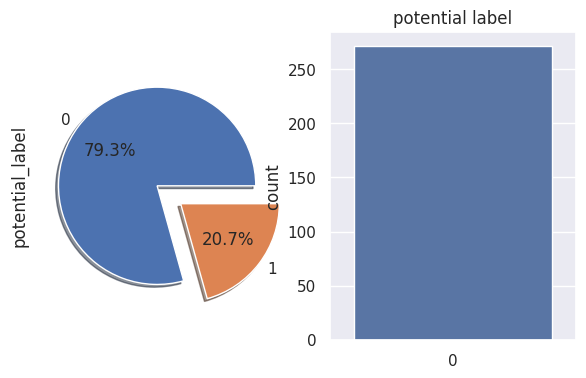

In [ ]:
# Hedef Değişken Dağılımını Gözlemleyelim;

fig,ax = plt.subplots(1,2,figsize = (7,4))
df_pvt["potential_label"].value_counts().plot.pie(explode= [0, .3], autopct = "%1.1f%%", shadow = True, ax = ax[0])
plt.title("potential label")
sns.countplot(df_pvt["potential_label"], ax= ax[1])
plt.show()

In [ ]:
def cv_result(model,X,y,cv = 5, scoring = ["accuracy","precision","recall","f1","roc_auc"]):
  cv_model = cross_validate(model,X,y, n_jobs = -1 , cv = cv, scoring = scoring)
  for metric in list(cv_model.keys())[2:]:
    score = cv_model[metric].mean()
    name = metric[5:]
    print(f"{name} :  {score}")
    print()


models = (("LR",LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ("GBM", GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier()),
          ("CatBoost", CatBoostClassifier(verbose=False)))

for name,model in models:
  print(f"{name} METRİCS:")
  cv_result(model,X,y)
  print("#"*50)

LR METRİCS:
accuracy :  0.8451178451178452

precision :  0.6964069264069264

recall :  0.4636363636363637

f1 :  0.5410814022578728

roc_auc :  0.8353417899929528

##################################################
KNN METRİCS:
accuracy :  0.8523232323232325

precision :  0.9333333333333332

recall :  0.3196969696969697

f1 :  0.4656841198017669

roc_auc :  0.8051268498942917

##################################################
CART METRİCS:
accuracy :  0.8268686868686869

precision :  0.6050267379679145

recall :  0.693939393939394

f1 :  0.6319327731092436

roc_auc :  0.7772022551092319

##################################################
RF METRİCS:
accuracy :  0.8929292929292929

precision :  0.9636363636363636

recall :  0.5136363636363637

f1 :  0.6543648763853367

roc_auc :  0.906571529245948

##################################################
GBM METRİCS:
accuracy :  0.8560269360269361

precision :  0.7098901098901098

recall :  0.5136363636363637

f1 :  0.5884444444444444

roc_a

In [ ]:
# LightGBM para_opt
lgbm_model = LGBMClassifier().fit(X,y)

lgbm_params = {"learning_rate" : [0.01,0.02,0.05,0.1],
               "n_estimators" : [200,300,350,400],
               "colsample_bytree" : [0.9,0.8,1]}

lgbm_grid = GridSearchCV(lgbm_model, lgbm_params, cv = 10, n_jobs = -1, verbose =True).fit(X,y)

lgbm_final = lgbm_model.set_params(**lgbm_grid.best_params_).fit(X,y)

cv_result(lgbm_model,X,y)

[LightGBM] [Info] Number of positive: 56, number of negative: 215
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 271, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206642 -> initscore=-1.345286
[LightGBM] [Info] Start training from score -1.345286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

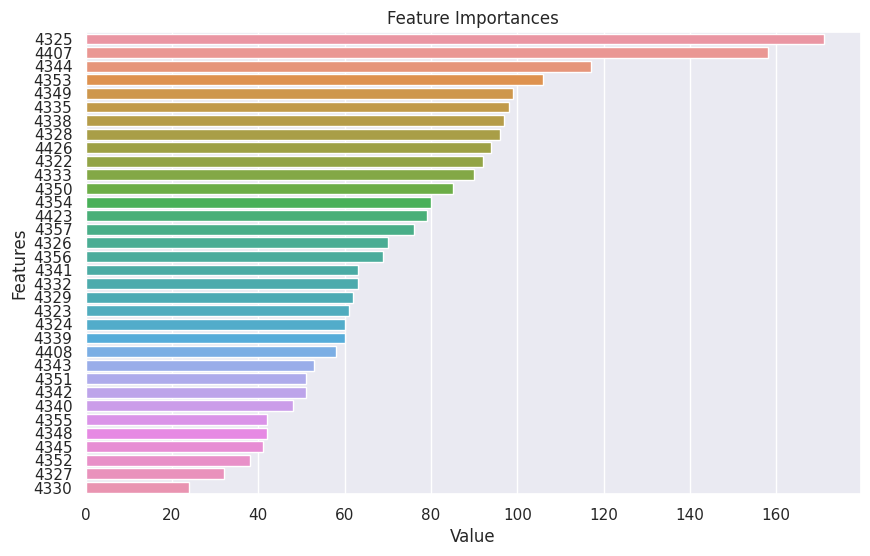

In [ ]:
# Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizelim.

def importances_plot(model, feature_name = list(X.columns), num= len(X), save=False):
  features_imp = pd.DataFrame({"Value" : model.feature_importances_, "Features" : feature_name})

  plt.figure(figsize = (10,6))
  plt.tight_layout()
  sns.barplot(x = "Value", y = "Features", data = features_imp.sort_values(by = "Value", ascending = False)[:num])
  plt.title("Feature Importances")
  sns.set(font_scale = 1)
  plt.show()

  if save:
    plt.figsave("importances.png")

importances_plot(lgbm_final)